In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import funcs as f
from itertools import combinations 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
import category_encoders as ce
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

# Bryan wuz here... X
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import category_encoders as ce

import vtreat
import vtreat.util

from matplotlib import pyplot as plt
import seaborn as sns


rand_state = 42

#import libraries
import numpy as np
import pandas as pd
from os import path as op

import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import minmax_scale
import category_encoders as ce
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

import vtreat
import vtreat.util

import xgboost as xgb
from xgboost import XGBClassifier
import xgbfir

from matplotlib import pyplot as plt
import seaborn as sns
# warnings.simplefilter(action='ignore', category=FutureWarning)
import KTBoost.KTBoost as KTBoost

import warnings
warnings.filterwarnings("ignore")

In [52]:
data = pd.read_csv('student-data.csv')
#renam passed as target
data.rename(columns={"passed": "target"}, inplace = True)
#relabel target to find failing students no:1 yes :0
data['target'] = data['target'].map({'no':0, 'yes':1})

In [53]:
data['absences_binned'] = data['absences'].apply(f.abs_bin)

## Split the data into by gender 

In [61]:
data_F = data[data['sex']=='F']
data_M = data[data['sex']=='M']

In [62]:
data_F_abs = data_F[data_F['absences_binned']!=0]

In [63]:
yF = data_F_abs['target']
del data_F_abs['target']
data_F_abs.drop(columns = ['absences'], inplace = True)
XF = data_F_abs.astype(str)



In [42]:
yM = data_M['target']
del data_M['target']
XM = data_M.astype(str)

### Using SelectFromModel to select features 

In [14]:
encoderF = ce.target_encoder.TargetEncoder()
selectF = SelectFromModel(lasso, threshold=0.25)
X_encF = encoderF.fit_transform(XF.values,yF.values)
X_SFMF = selectF.fit_transform(X_encF,yF)


feature_idx = selectF.get_support()
feature_name = data_F_abs.columns[feature_idx]
feature_name


Index(['school', 'address', 'Pstatus', 'Medu', 'Mjob', 'reason', 'traveltime',
       'studytime', 'failures', 'schoolsup', 'famsup', 'higher', 'famrel',
       'goout', 'Walc'],
      dtype='object')

In [43]:
encoderM = ce.target_encoder.TargetEncoder()
selectM = SelectFromModel(lasso, threshold=0.25)
X_encM = encoderM.fit_transform(XM.values,yM.values)
X_SFMM = selectM.fit_transform(X_encM,yM)

feature_idx = selectM.get_support()
feature_name = data_M.columns[feature_idx]
feature_name

Index(['school', 'age', 'address', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob',
       'reason', 'guardian', 'failures', 'schoolsup', 'activities', 'higher',
       'internet', 'romantic', 'goout', 'health', 'absences_binned'],
      dtype='object')

### Training Score for Female Population

In [15]:
scoreF = cross_val_score(clf, X_SFMF, yF.values, cv=5, scoring='roc_auc')
print(scoreF.mean(), "+/-", scoreF.std())

0.5800925925925926 +/- 0.0672798447042601


### Training Score for Male Population

In [44]:
scoreM = cross_val_score(clf, X_SFMM, yM.values, cv=3, scoring='roc_auc')
print(scoreM.mean(), "+/-", scoreM.std())

0.7398325358851675 +/- 0.016979748285380833


## Modeling for Female Group

In [64]:
XF.drop(columns=['sex'], inplace = True)

In [65]:
FX_train, FX_test, Fy_train, Fy_test = train_test_split(XF, yF, test_size = 0.3, random_state = 42, stratify = yF)


In [66]:
#target encode the training data
#concat the X_train and y_train to target encode
F_train =pd.concat([FX_train, Fy_train], axis = 1)


In [67]:
#create new df for encoded features
FX_train_enc = pd.DataFrame()
FX_test_enc = pd.DataFrame()

for col in FX_train.columns.to_list():
    #means has col cats and their means
    means = F_train.groupby(col).target.mean()
    #makes new col in new XTrain of encoded cols
    FX_train_enc[col] = FX_train[col].map(means)
    #makes new col in new Xtest of encoded cols using map from train data
    #no leakage
    FX_test_enc[col] = FX_test[col].map(means)

In [68]:
#fit model on train data using encoded train set
lasso = LogisticRegressionCV(class_weight='balanced',
                             penalty='l1',scoring='roc_auc',
                             solver='liblinear')
selectF = SelectFromModel(lasso, threshold=0.25)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(selectF, clf)
score = cross_val_score(pipe, FX_train_enc.values, Fy_train.values, cv=5, scoring='roc_auc')

In [69]:
print(score.mean(), "+/-", score.std())

0.6739795918367347 +/- 0.058695894363906397


In [70]:
selectF = SelectFromModel(lasso, threshold=.25)
X_SFMF = selectF.fit_transform(FX_train_enc, Fy_train)


feature_idx = selectF.get_support()
feature_name = FX_train_enc.columns[feature_idx]
selected = feature_name.to_list()
feature_name




Index(['age', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason',
       'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup',
       'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
       'romantic', 'famrel', 'freetime', 'goout', 'Walc', 'health',
       'absences_binned'],
      dtype='object')

In [71]:
clf.fit(X_SFMF, Fy_train.values)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
predictions = clf.predict(FX_test_enc[selected])
from sklearn.metrics import classification_report
print(roc_auc_score(Fy_test,predictions))

0.6215880893300247


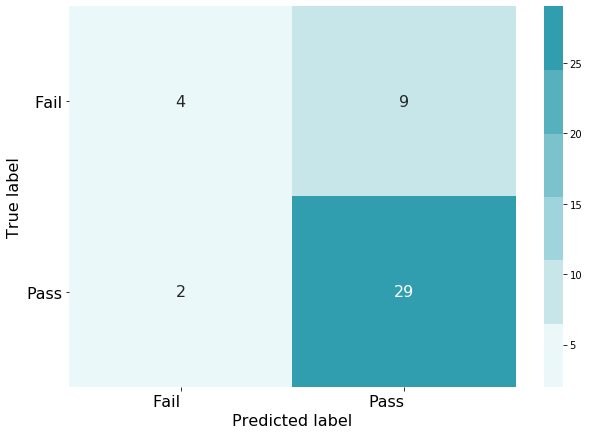

In [74]:
f.print_confusion_matrix(confusion_matrix(Fy_test, predictions), ["Fail", "Pass"],  cmap = sns.light_palette((210, 90, 60), input="husl"), name = "FemaleFinal.jpg");


# Modeling the Male Data

In [45]:
# XM.drop(columns=['absences'], inplace = True)
MX_train, MX_test, My_train, My_test = train_test_split(XM, yM, test_size = 0.3, random_state = rand_state, stratify = yM)

#target encode the training data
#concat the X_train and y_train to target encode
M_train =pd.concat([MX_train, My_train], axis = 1)

#create new df for encoded features
MX_train_enc = pd.DataFrame()
MX_test_enc = pd.DataFrame()

for col in MX_train.columns.to_list():
    #means has col cats and their means
    means = M_train.groupby(col).target.mean()
    #makes new col in new XTrain of encoded cols
    MX_train_enc[col] = MX_train[col].map(means)
    #makes new col in new Xtest of encoded cols using map from train data
    #no leakage
    MX_test_enc[col] = MX_test[col].map(means)
    


In [46]:
#fit model on train data using encoded train set
lasso = LogisticRegressionCV(class_weight='balanced',
                             penalty='l1',scoring='roc_auc',
                             solver='liblinear')
selectM = SelectFromModel(lasso, threshold=0.25)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(selectM, clf)
score = cross_val_score(pipe, MX_train_enc.values, My_train.values, cv=3, scoring='roc_auc')
print(score.mean(), "+/-", score.std())



0.782276445179671 +/- 0.030679635272325045


In [47]:
selectM = SelectFromModel(lasso, threshold=0.50)
X_SFMF = selectM.fit_transform(MX_train_enc, My_train)


feature_idx = selectM.get_support()
feature_name = MX_train_enc.columns[feature_idx]
feature_name




Index(['Medu', 'Fedu', 'failures', 'schoolsup', 'goout', 'Dalc',
       'absences_binned'],
      dtype='object')

In [48]:
selected = feature_name.to_list()

In [49]:
clf.fit(X_SFMF, My_train.values)

predictions = clf.predict(MX_test_enc[selected])
from sklearn.metrics import classification_report
print(roc_auc_score(My_test,predictions))

0.7441176470588236


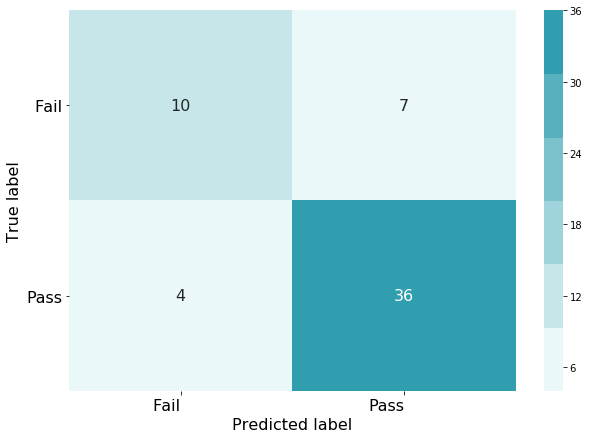

In [50]:
f.print_confusion_matrix(confusion_matrix(My_test, predictions), ["Fail", "Pass"],  cmap = sns.light_palette((210, 90, 60), input="husl"), name = "MaleFinal.jpg");
